In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import matplotlib.pyplot as plt

# Check current directory and fix the path
print("Current directory:", os.getcwd())

# Use absolute path or adjust relative path from notebook location
DATA_ROOT = os.path.join(os.path.dirname(os.getcwd()), "dataset_cnn_specs")
print("Looking for data at:", DATA_ROOT)
print("Directory exists:", os.path.exists(DATA_ROOT))

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_ROOT,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=SEED,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_ROOT,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
)

class_names = train_ds.class_names
print("Class names:", class_names)  # should be ['anthro', 'nature'] or vice versa


Current directory: d:\Projects\QuietHorizon\quiet_horizon\cnn_generation
Looking for data at: d:\Projects\QuietHorizon\quiet_horizon\dataset_cnn_specs
Directory exists: True
Found 23208 files belonging to 2 classes.
Found 23208 files belonging to 2 classes.
Using 18567 files for training.
Using 18567 files for training.
Found 23208 files belonging to 2 classes.
Found 23208 files belonging to 2 classes.
Using 4641 files for validation.
Class names: ['anthro', 'nature']
Using 4641 files for validation.
Class names: ['anthro', 'nature']


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)


In [5]:
input_shape = IMG_SIZE + (3,)  # RGB PNG

model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=input_shape),

    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid"),  # binary
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.AUC(name="auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ],
)

model.summary()


d:\Projects\QuietHorizon\venv\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,441 (1.61 MB)

 Trainable params: 421,441 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
EPOCHS = 20

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "models/quiet_horizon_cnn.keras",
        save_best_only=True,
        monitor="val_auc",
        mode="max",
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_auc",
        patience=4,
        mode="max",
        restore_best_weights=True,
    ),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
)


Epoch 1/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.7464 - auc: 0.8283 - loss: 0.4952 - precision: 0.7404 - recall: 0.8733 - val_accuracy: 0.8731 - val_auc: 0.9384 - val_loss: 0.3011 - val_precision: 0.8763 - val_recall: 0.9171
Epoch 2/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.7464 - auc: 0.8283 - loss: 0.4952 - precision: 0.7404 - recall: 0.8733 - val_accuracy: 0.8731 - val_auc: 0.9384 - val_loss: 0.3011 - val_precision: 0.8763 - val_recall: 0.9171
Epoch 2/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accuracy: 0.8754 - auc: 0.9373 - loss: 0.3032 - precision: 0.8667 - recall: 0.9304 - val_accuracy: 0.9007 - val_auc: 0.9589 - val_loss: 0.2442 - val_precision: 0.8737 - val_recall: 0.9748
Epoch 3/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accuracy: 0.8754 - auc: 0.9373 - loss: 0.3032 - precision: 0.8667 - recall: 0.9304 - val_accuracy: 0.9007 - val_auc: 0.9589 - val_loss: 0.2442 - val_precision: 0.8737 - val_recall: 0.9748
Epoch 3/20
581/581 ━━━━━

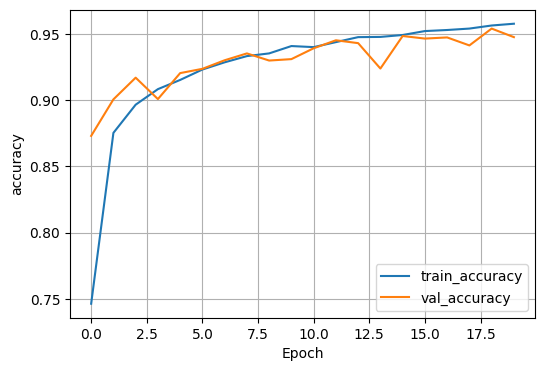

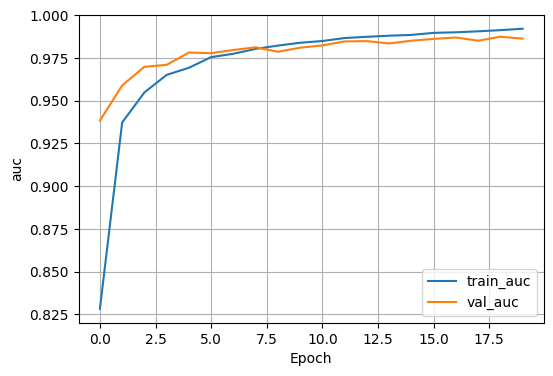

In [7]:
def plot_history(history, metric="accuracy"):
    plt.figure(figsize=(6,4))
    plt.plot(history.history[metric], label=f"train_{metric}")
    plt.plot(history.history[f"val_{metric}"], label=f"val_{metric}")
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history, "accuracy")
plot_history(history, "auc")


In [8]:
val_loss, val_acc, val_auc, val_prec, val_rec = model.evaluate(val_ds)
print(f"Val: loss={val_loss:.3f}, acc={val_acc:.3f}, auc={val_auc:.3f}, "
      f"precision={val_prec:.3f}, recall={val_rec:.3f}")

# Look at a small batch
batch_images, batch_labels = next(iter(val_ds))
probs = model.predict(batch_images)
preds = (probs > 0.5).astype("int32").flatten()

for i in range(5):
    label = int(batch_labels[i].numpy())
    print(f"Sample {i}: true={label}, pred={preds[i]}, prob={probs[i][0]:.3f}")


146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9541 - auc: 0.9874 - loss: 0.1294 - precision: 0.9588 - recall: 0.9647
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9541 - auc: 0.9874 - loss: 0.1294 - precision: 0.9588 - recall: 0.9647
Val: loss=0.129, acc=0.954, auc=0.987, precision=0.959, recall=0.965
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/stepVal: loss=0.129, acc=0.954, auc=0.987, precision=0.959, recall=0.965
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Sample 0: true=0, pred=0, prob=0.008
Sample 1: true=0, pred=0, prob=0.001
Sample 2: true=1, pred=1, prob=1.000
Sample 3: true=0, pred=0, prob=0.000
Sample 4: true=1, pred=1, prob=1.000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Sample 0: true=0, pred=0, prob=0.008
Sample 1: true=0, pred=0, prob=0.001
Sample 2: true=1, pred=1, prob=1.000
Sample 3: true=0, pred=0, prob=0.000
Sample 4: true=1, pred=1, prob=1.000


C:\Users\beau_\AppData\Local\Temp\ipykernel_48204\4149715726.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(batch_labels[i].numpy())
